# Exploració de dades

In [ ]:
# Importació de llibreries

import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import plot_tree


In [ ]:
#Importació del conjunt de dades a anàlitzar

crimes = pd.read_csv('/Crime.csv', sep = ",")

<ipython-input-43-92006c6d34d2>:3: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  crimes = pd.read_csv('/Crime.csv', sep = ",")


In [ ]:
#Preparació de dades per l'anàlisi

dades = crimes.iloc[:, [0,4,6,7,8,9,10,13, 15,25, 26,27, 28]].copy() #Triem les variables volgudes per realitzar l'anàlisi.

dades = dades.dropna() #Eliminem Na's

#Transformació variable Start Date Time
dades[["Date", "Time"]] = dades["Start_Date_Time"].str.split(" ", n= 1, expand=True) #Separem data i hora.
#Cambiem format data i hora als europeus.
dades["Date"] = pd.to_datetime(dades["Date"],format="%m/%d/%Y").dt.strftime("%d/%m/%Y")
dades["Time"] = pd.to_datetime(dades["Time"], format="%I:%M:%S %p").dt.strftime("%H:%M:%S")

#Eliminem dades repetides (la columna Start_Date_Time)
dades = dades.drop(columns=["Start_Date_Time"])

#Ajuntem crims duplicats (1 persona per incident)
dades = dades.groupby("Incident ID", as_index=False).agg({
    'Victims': 'sum', 'NIBRS Code': 'first', 'Crime Name1': 'first',
    'Crime Name2': 'first',
    'Crime Name3': 'first',
    'City': 'first',
    'Latitude': 'first',
    'Longitude': 'first',
    "Zip Code": "first",
    'Police District Number': 'first',
    'Street Type': 'first',
    'Date': 'first',
    'Time': 'first',
})
dades = dades[(dades['Latitude'] != 0) & (dades['Longitude'] != 0)]
# Fem una dupliació de dades amb les columnes Date i time són expressades amb decimals

dades1 = dades.copy()
def time_to_decimal(time_str):
    if pd.isna(time_str):
        return np.nan
    hours, minutes, seconds = map(int, time_str.split(':'))
    return hours/24 + minutes / 1440 + seconds / 86400

dades1['Time'] = dades['Time'].apply(time_to_decimal)
dades1['Date'] = pd.to_datetime(dades['Date'], format='%d/%m/%Y').dt.dayofyear/pd.to_datetime(dades['Date'], format='%d/%m/%Y').dt.is_leap_year.apply(lambda x: 366 if x else 365)

# També creem una columna més a indicar l'any que hi havia passat el crim

dades1['Year']=pd.to_datetime(dades['Date'], format='%d/%m/%Y').dt.year

# Finalment reescalem les tres dades que hem obtingut abans
dades = dades1
dades1.head(1)

,Incident ID,Victims,NIBRS Code,Crime Name1,Crime Name2,Crime Name3,City,Latitude,Longitude,Zip Code,Police District Number,Street Type,Date,Time,Year
0,201087096,1,23H,Crime Against Property,All other Larceny,LARCENY (DESCRIBE OFFENSE),GERMANTOWN,39.17853,-77.263,20874.0,5D,DR,0.5,0.015278,2016


In [ ]:
dades.info()

<class 'pandas.core.frame.DataFrame'>
Index: 378743 entries, 0 to 389249
Data columns (total 15 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Incident ID             378743 non-null  int64  
 1   Victims                 378743 non-null  int64  
 2   NIBRS Code              378743 non-null  object 
 3   Crime Name1             378743 non-null  object 
 4   Crime Name2             378743 non-null  object 
 5   Crime Name3             378743 non-null  object 
 6   City                    378743 non-null  object 
 7   Latitude                378743 non-null  float64
 8   Longitude               378743 non-null  float64
 9   Zip Code                378743 non-null  float64
 10  Police District Number  378743 non-null  object 
 11  Street Type             378743 non-null  object 
 12  Date                    378743 non-null  float64
 13  Time                    378743 non-null  float64
 14  Year                    3

In [ ]:
print("Dimensió de les dades:", dades.shape)

Dimensió de les dades: (378743, 15)


#Estadístiques descriptives

In [ ]:
dades["Victims"].describe()

,Victims
count,378743.000000
mean,1.113803
std,0.414796
min,1.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,22.000000


Visualitzem la gràfica del nombre víctims segon la variable Victims:

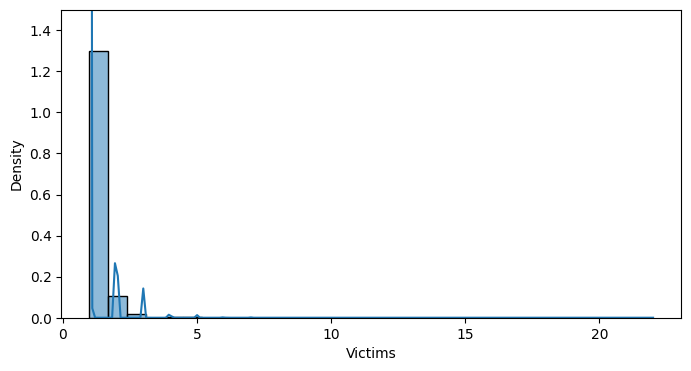

In [ ]:
#Visualització gràfica: histograma de "Victims"

plt.figure(figsize=(8, 4))
sns.histplot(dades["Victims"], kde=True, bins=30, stat="density")
plt.ylim(0, 1.5)
plt.show()

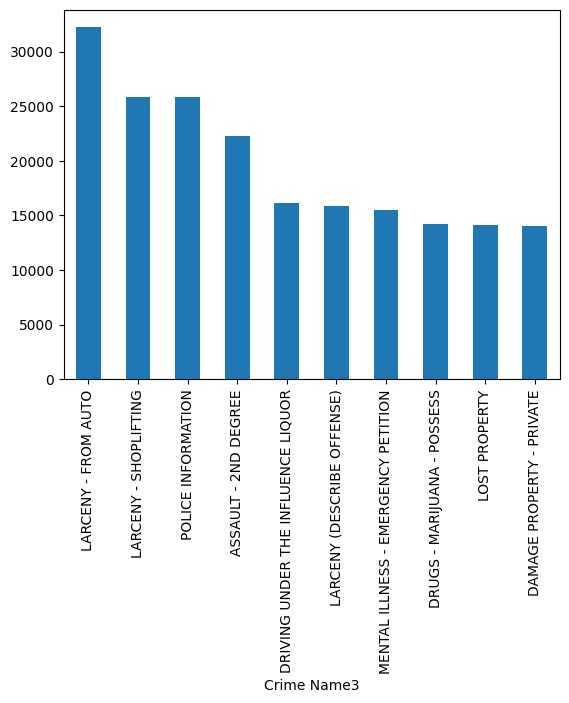

In [ ]:
cr = dades["Crime Name3"].value_counts().head(10)
cr.plot(kind="bar")
plt.show()

També ara visualitzem la gràfica del nombre d'ocurrències de diferents tipus de crims segon la variable NIBRS Code del data frame dades1.

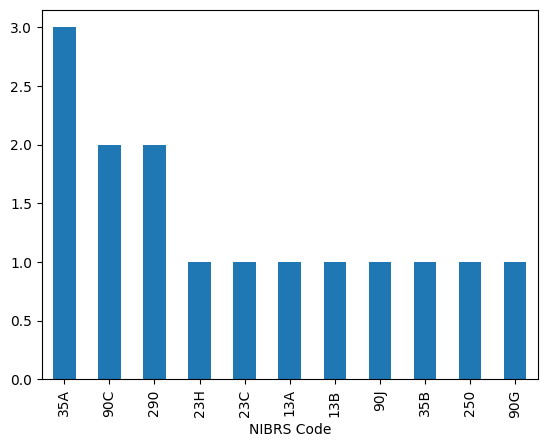

In [ ]:
dades1["NIBRS Code"].head(15).value_counts().plot(kind="bar")
plt.show()

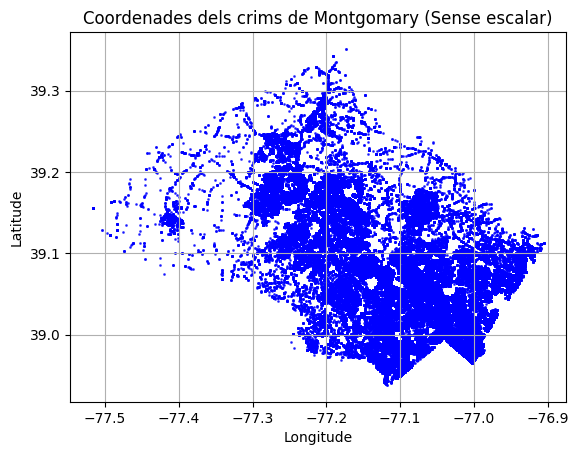

In [ ]:
longitude = dades['Longitude']
latitude = dades['Latitude']

plt.scatter(longitude, latitude, color='blue', alpha=0.7, s=1)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Coordenades dels crims de Montgomary (Sense escalar)')
plt.grid(True)
plt.show()

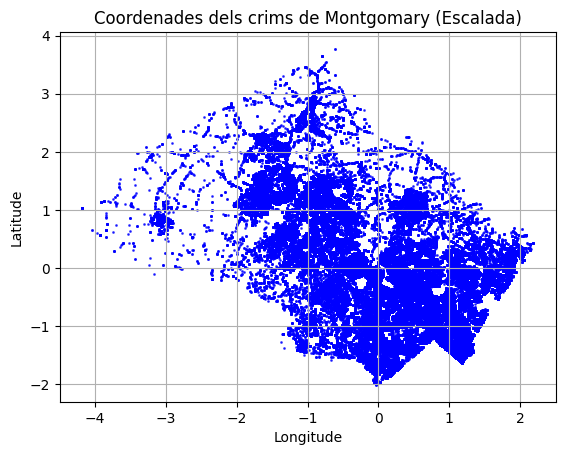

In [ ]:
dades["Longitude"] = (dades["Longitude"] - dades["Longitude"].mean()) / dades["Longitude"].std()
dades["Latitude"] = (dades["Latitude"] - dades["Latitude"].mean()) / dades["Latitude"].std()

longitude = dades['Longitude']
latitude = dades['Latitude']

plt.scatter(longitude, latitude, color='blue', alpha=0.7, s=1)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Coordenades dels crims de Montgomary (Escalada)')
plt.grid(True)
plt.show()


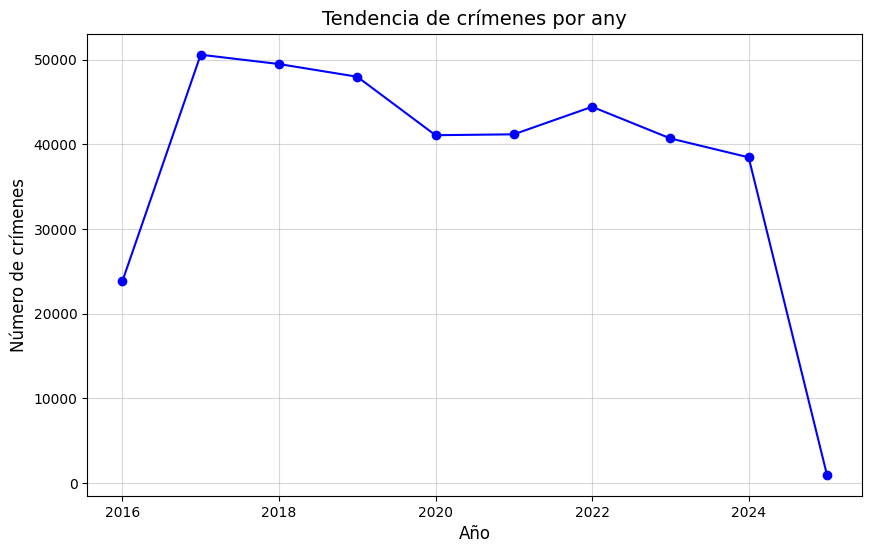

In [ ]:
#Serie temporal crims
crimes_any = dades.groupby("Year").size()
plt.figure(figsize=(10, 6))
plt.plot(crimes_any.index, crimes_any.values, marker="o", color="blue")
plt.title("Tendència de crímenes por any", fontsize=14)
plt.xlabel("Año", fontsize=12)
plt.ylabel("Número de crímenes", fontsize=12)
plt.grid(alpha=0.5)
plt.show()


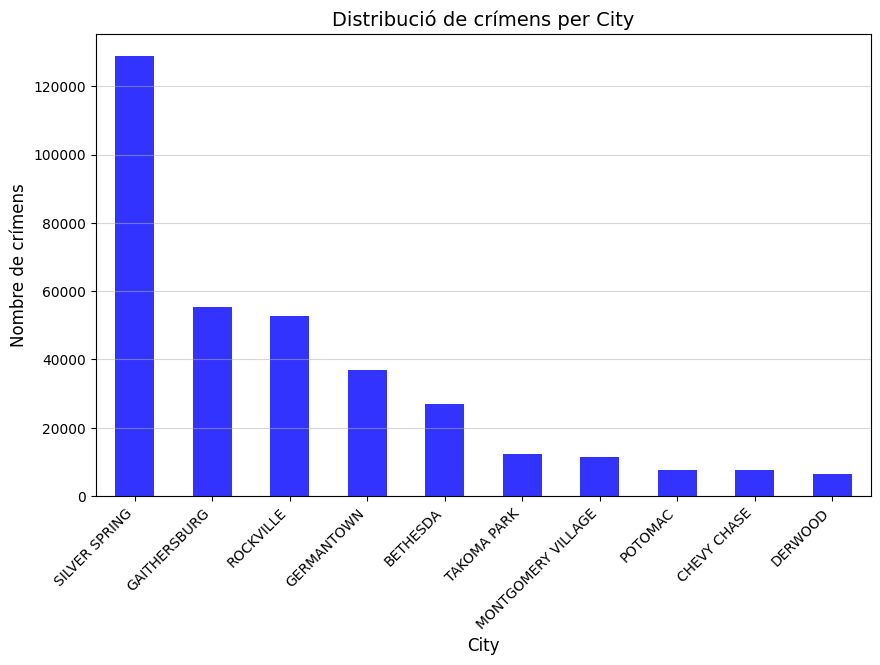

In [ ]:
crimes_city = dades.groupby("City").size()
plt.figure(figsize=(10, 6))
crimes_city.sort_values(ascending=False).head(10).plot(kind='bar', color="blue", alpha=0.8)
plt.title("Distribució de crímens per City", fontsize=14)
plt.xlabel("City", fontsize=12)
plt.ylabel("Nombre de crímens", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", alpha=0.5)
plt.show()

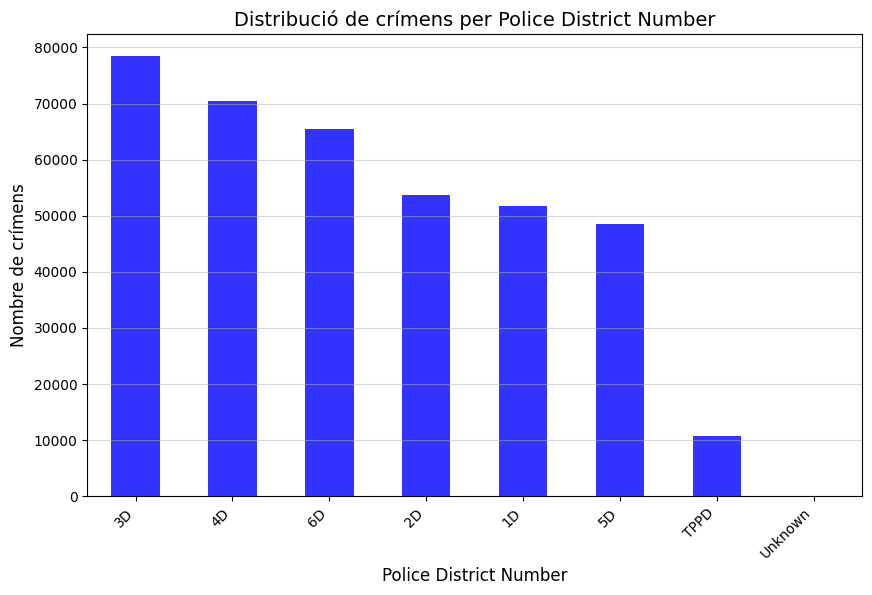

In [ ]:
#Ddistribución - Police District Number
crimes_police_district = dades.groupby("Police District Number").size()
plt.figure(figsize=(10, 6))
crimes_police_district.sort_values(ascending=False).head(10).plot(kind='bar', color="blue", alpha=0.8)
plt.title("Distribució de crímens per Police District Number", fontsize=14)
plt.xlabel("Police District Number", fontsize=12)
plt.ylabel("Nombre de crímens", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", alpha=0.5)
plt.show()

#Aplicació d'algorismes d'aprenentatge automàtic

## K-nn

In [ ]:
# Analitzem les dades que només són més de 2 víctims per a estalviar el temp del
#cálcul

crims_greus = dades1[dades1["Victims"] > 2]
crims_greus["Longitude"] = (crims_greus["Longitude"] - crims_greus["Longitude"].mean()) / crims_greus["Longitude"].std()
crims_greus["Latitude"] = (crims_greus["Latitude"] - crims_greus["Latitude"].mean()) / crims_greus["Latitude"].std()
crims_greus["Date"] = (crims_greus["Date"] - crims_greus["Date"].mean()) / crims_greus["Date"].std()
crims_greus["Time"] = (crims_greus["Time"] - crims_greus["Time"].mean()) / crims_greus["Time"].std()
crims_greus["Year"] = (crims_greus["Year"] - crims_greus["Year"].mean()) / crims_greus["Year"].std()

explanatory_variables = crims_greus[['Longitude', 'Latitude', 'Date', 'Time', 'Year']].columns
target_variable_victims = crims_greus[['City']].columns

X_City = crims_greus[explanatory_variables]
y_City = crims_greus[target_variable_victims].astype("category")

<ipython-input-49-3b47f9937374>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crims_greus["Longitude"] = (crims_greus["Longitude"] - crims_greus["Longitude"].mean()) / crims_greus["Longitude"].std()
<ipython-input-49-3b47f9937374>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crims_greus["Latitude"] = (crims_greus["Latitude"] - crims_greus["Latitude"].mean()) / crims_greus["Latitude"].std()
<ipython-input-49-3b47f9937374>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_City, y_City, test_size=0.2, random_state=1)

In [ ]:
def knn(k):
  model = KNeighborsClassifier(n_neighbors=k).fit(X_train, y_train)
  y_pred_train = model.predict(X_train)
  y_pred_test = model.predict(X_test)
  acc_train = accuracy_score(y_train, y_pred_train)
  acc_test = accuracy_score(y_test, y_pred_test)

  return acc_train, acc_test

/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for 

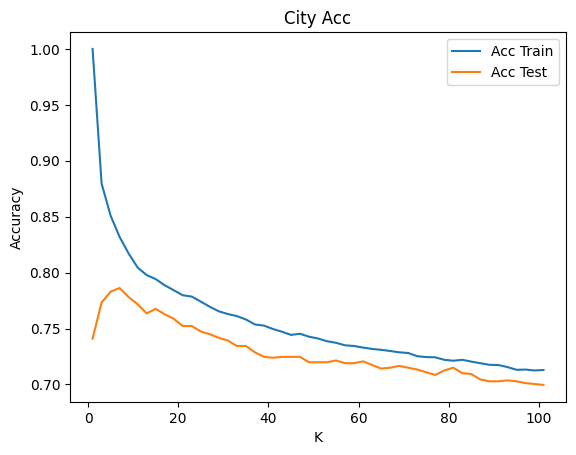

In [ ]:
accs_train = []
accs_test = []

ks = range(1, 102, 2)

for k in ks:
  acc_train, acc_test = knn(k)
  accs_train.append(acc_train)
  accs_test.append(acc_test)

plt.plot(ks, accs_train, label="Acc Train")
plt.plot(ks, accs_test, label="Acc Test")
plt.xlabel("K")
plt.ylabel("Accuracy")
plt.title("City Acc")
plt.legend()
plt.show()

Podem veure que aquest model de knn té l'accuracy asimptòtica a prop del 0.7 i 0.8. Aquest nombre no és un model ideal si volem fer unes prediccions precises, però amb la complexitat de la base de dades que hem triat, és el millor que podem tenir. L'algoritme Knn de classificació és un métode de predicció d'un punt a base del les categories dels punts propers.



In [ ]:
explanatory_variables = crims_greus[['Longitude', 'Latitude']].columns
target_variable_victims = crims_greus[['City']].columns

X_City = crims_greus[explanatory_variables]
y_City = crims_greus[target_variable_victims].astype("category")

/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for 

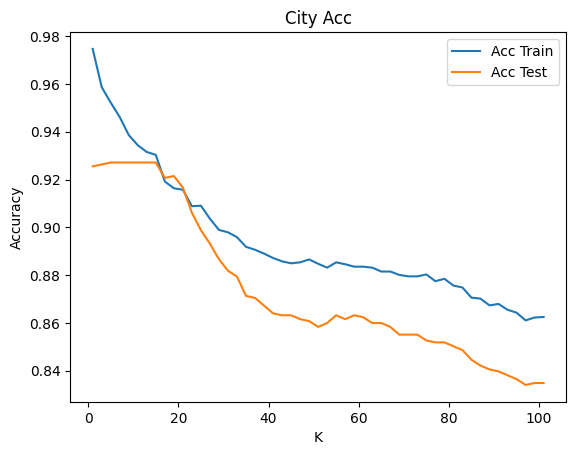

In [ ]:
accs_train = []
accs_test = []

ks = range(1, 102, 2)

for k in ks:
  acc_train, acc_test = knn(k)
  accs_train.append(acc_train)
  accs_test.append(acc_test)

plt.plot(ks, accs_train, label="Acc Train")
plt.plot(ks, accs_test, label="Acc Test")
plt.xlabel("K")
plt.ylabel("Accuracy")
plt.title("City Acc")
plt.legend()
plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


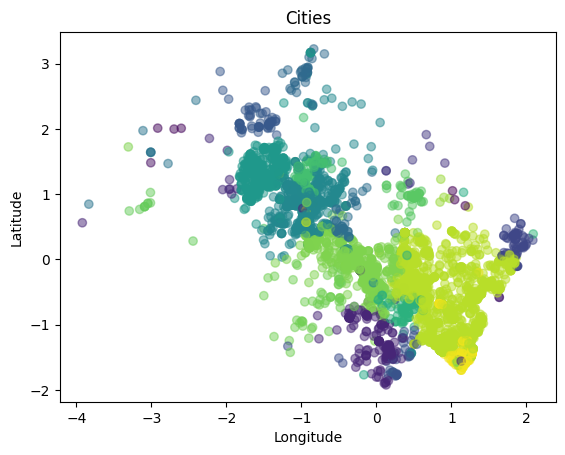

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_City, y_City, test_size=0.2, random_state=1)

model = KNeighborsClassifier(n_neighbors=19).fit(X_train, y_train)

x_min, x_max = X_train.iloc[:, 0].min() - 0.1, X_train.iloc[:, 0].max() + 0.1
y_min, y_max = X_train.iloc[:, 1].min() - 0.1, X_train.iloc[:, 1].max() + 0.1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.05), np.arange(y_min, y_max, 0.05))
Z = model.predict(np.c_[xx.ravel(), yy.ravel()])

Z = Z.reshape(xx.shape)

city_labels = y_train['City'].cat.codes

plt.scatter(X_train["Longitude"], X_train["Latitude"], c=city_labels, alpha=0.5)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Cities")
plt.show()


## Arbre de decisió

In [ ]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.multioutput import MultiOutputRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Codificació variables categòriques utilitzades en aquest anàlisi
label_enc = LabelEncoder()
for col in ['NIBRS Code', 'Crime Name1', 'Crime Name2', 'Crime Name3', 'City', 'Police District Number', 'Street Type']:
    dades[col] = label_enc.fit_transform(dades[col].astype(str))

#Arbre de decisió - Regressor


# Definir variables explicativas y targets
explanatory_variables = [
    "NIBRS Code",
    "Crime Name1",
    "Crime Name2",
    "Crime Name3",
    "Street Type",
    "Year",
    "Date",
    "Time",
    "Year",
    "Police District Number"
]

target_variables = ["Latitude", "Longitude"]

X = dades[explanatory_variables]
y = dades[target_variables]

#Entrenar el model (utilitzem MultiOutputRegressor per fer els dos targets alhora)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
regressor = MultiOutputRegressor(DecisionTreeRegressor(random_state=42, max_depth=10, min_samples_leaf=5))
regressor.fit(X_train, y_train)
y_pred_train = regressor.predict(X_train)
y_pred_test = regressor.predict(X_test)

#Mètriques
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

print(f"MSE (entrenamiento): {mse_train}")
print(f"MSE (prueba): {mse_test}")
print(f"R2 (prueba): {r2_test}")

MSE (entrenamiento): 0.14522367066836622
MSE (prueba): 0.1459880794590705
R2 (prueba): 0.8530991262330341


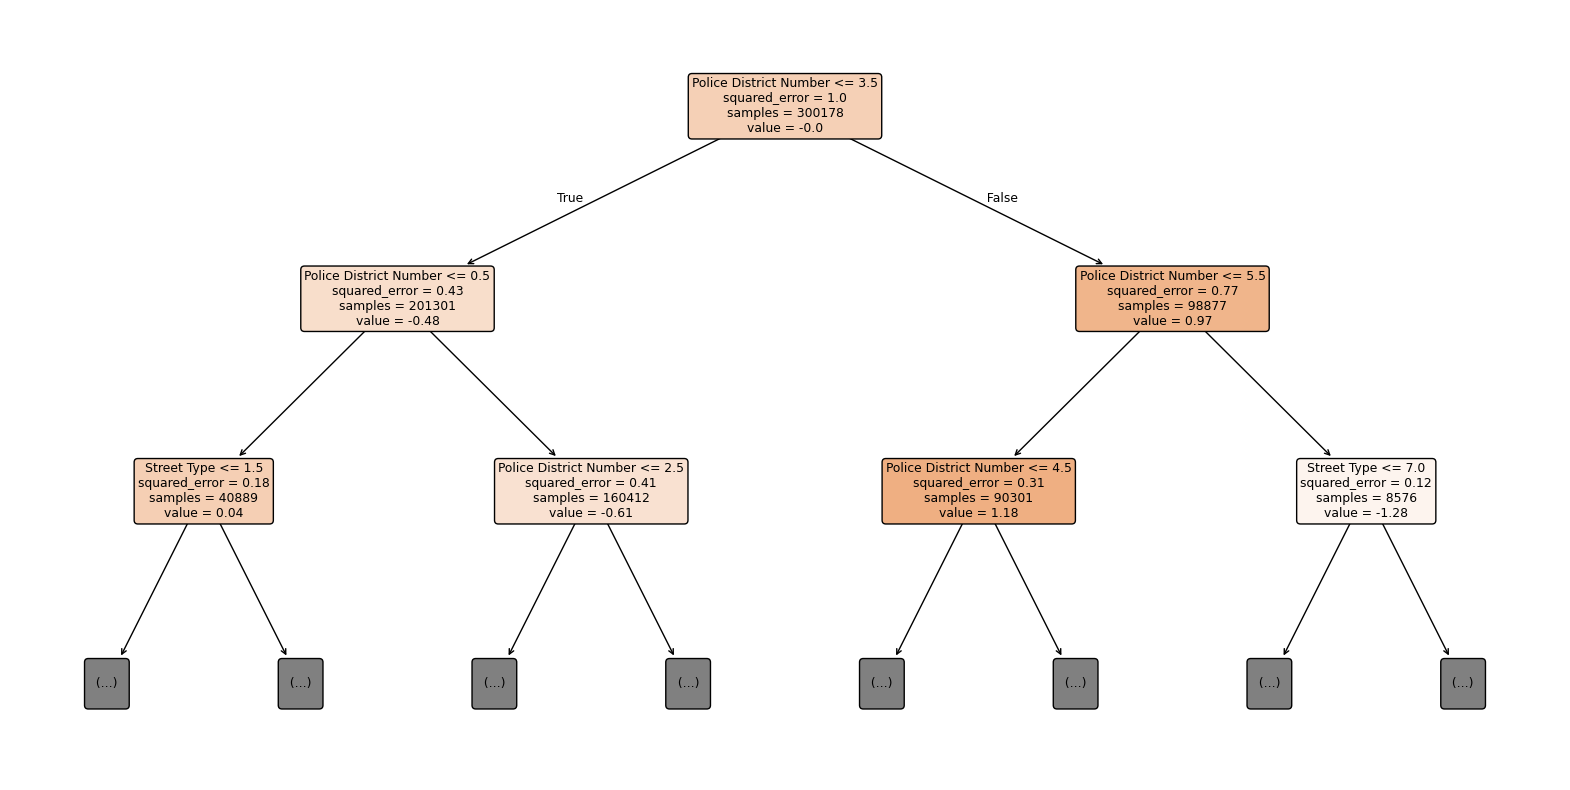

In [ ]:
from sklearn.tree import plot_tree
#Plot latitud
plt.figure(figsize=(20, 10))
plot_tree(regressor.estimators_[0], filled=True, feature_names=explanatory_variables,
          rounded=True,  max_depth=2, proportion=False, precision=2)
plt.show()


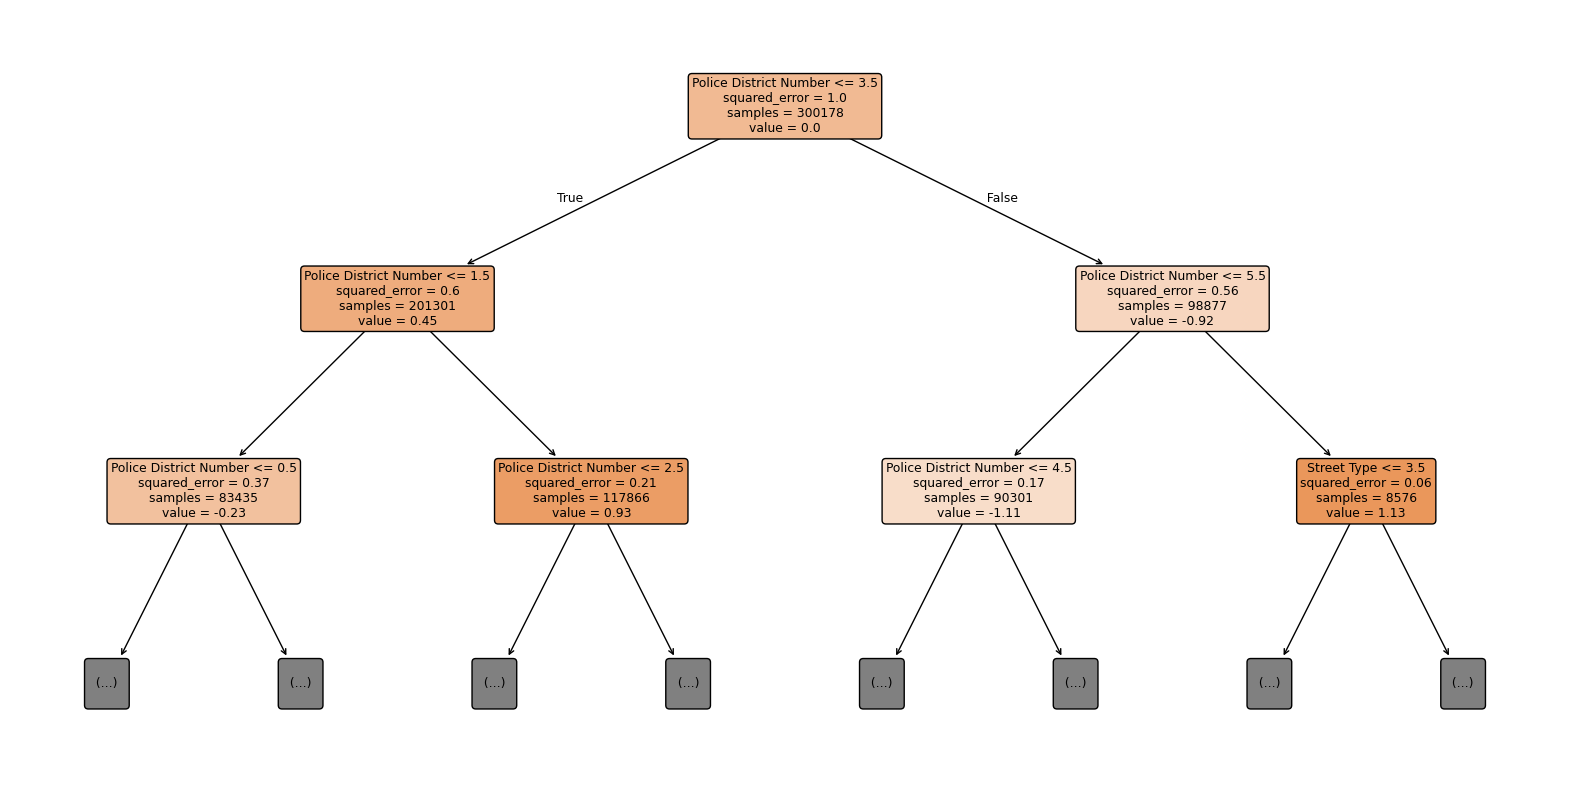

In [ ]:
from sklearn.tree import plot_tree
#Plot Longitud
plt.figure(figsize=(20, 10))
plot_tree(regressor.estimators_[1], filled=True, feature_names=explanatory_variables,
          rounded=True,  max_depth=2, proportion=False, precision=2)
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
# Calcular les mètriques
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
mae_train = mean_absolute_error(y_train, y_pred_train)
mae_test = mean_absolute_error(y_test, y_pred_test)
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)
print(f"MSE (entrenament): {mse_train}")
print(f"MSE (prova): {mse_test}")
print(f"MAE (entrenament): {mae_train}")
print(f"MAE (prova): {mae_test}")
print(f"R2 (entrenament): {r2_train}")
print(f"R2 (prova): {r2_test}")

MSE (entrenament): 0.14522367066836622
MSE (prova): 0.1459880794590705
MAE (entrenament): 0.2641245764635354
MAE (prova): 0.26591422949719706
R2 (entrenament): 0.8549994082968253
R2 (prova): 0.8530991262330341


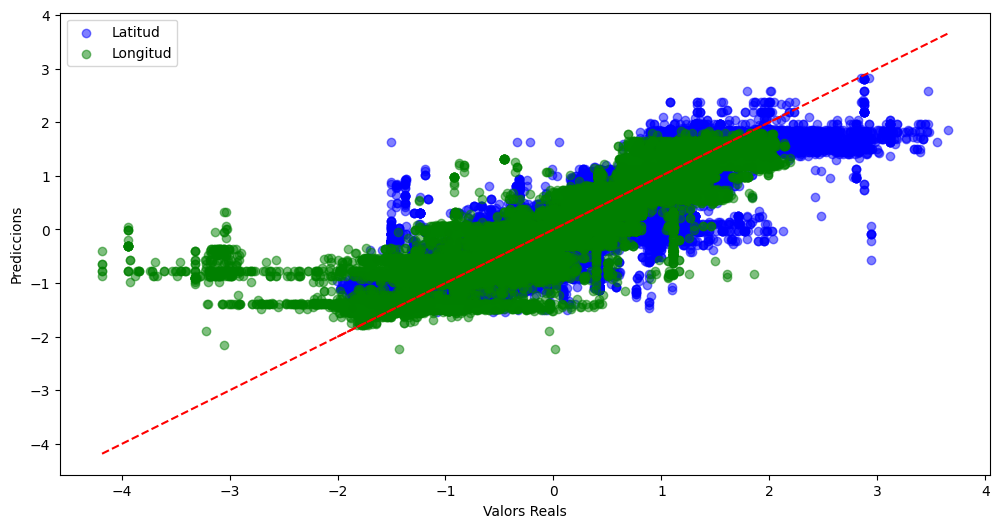

In [ ]:
plt.figure(figsize=(12, 6))
plt.scatter(y_test["Latitude"], y_pred_test[:, 0], color='blue', alpha=0.5, label="Latitud")
plt.scatter(y_test["Longitude"], y_pred_test[:, 1], color='green', alpha=0.5, label="Longitud")
plt.plot([y_test["Latitude"].min(), y_test["Latitude"].max()], [y_test["Latitude"].min(), y_test["Latitude"].max()], color='red', linestyle='--')
plt.plot([y_test["Longitude"].min(), y_test["Longitude"].max()], [y_test["Longitude"].min(), y_test["Longitude"].max()], color='red', linestyle='--')
plt.xlabel("Valors Reals")
plt.ylabel("Prediccions")
plt.legend()
plt.show()
